## Bank Marketing Analysis — Notebook & README

# 1. Title & Objective (markdown)

# Bank Marketing Campaign Analysis

**Objective:** Use the UCI Bank Marketing dataset to predict whether a customer will subscribe to a term deposit. This notebook includes EDA, feature engineering, a Random Forest baseline model, evaluation, and business insights suitable for a portfolio.

# 2. Setup & Imports (code)

In [1]:
# Cell: Setup & imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib

# plotting defaults
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (9,6)

# Paths
DATA_PATH = os.path.join('data','bank-additional-full.csv')
OUTPUT_DIR = 'outputs'
NOTEBOOK_PLOTS = os.path.join(OUTPUT_DIR,'notebook_plots')
MODELS_DIR = os.path.join(OUTPUT_DIR,'models')
os.makedirs(NOTEBOOK_PLOTS, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# 3. Load data & quick peek (code)

In [2]:
# Cell: load data
df = pd.read_csv(DATA_PATH, sep=';')
print('Shape:', df.shape)
df.head()

Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# 4. Basic profiling (code)

In [3]:
# Cell: basic profiling
print(df.info())
print('\nMissing values per column:')
print(df.isin(['unknown']).sum())
print('\nValue counts for target:')
print(df['y'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

# 5. Quick EDA visuals (code)

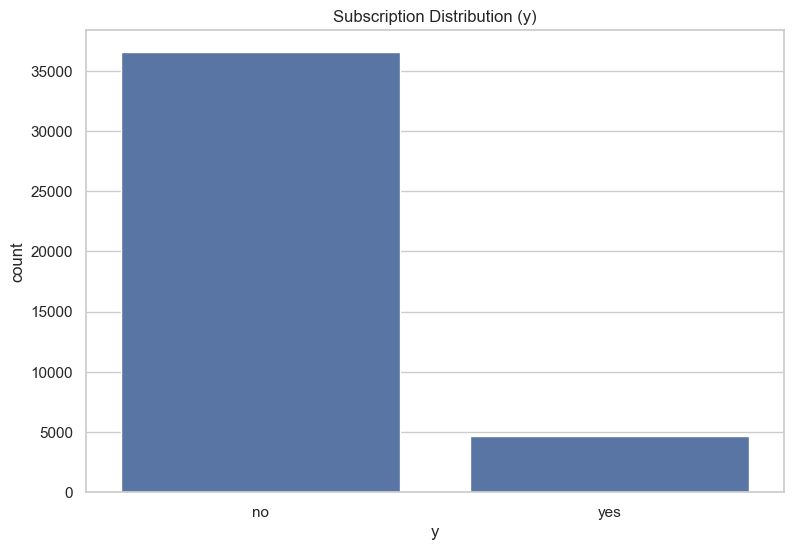

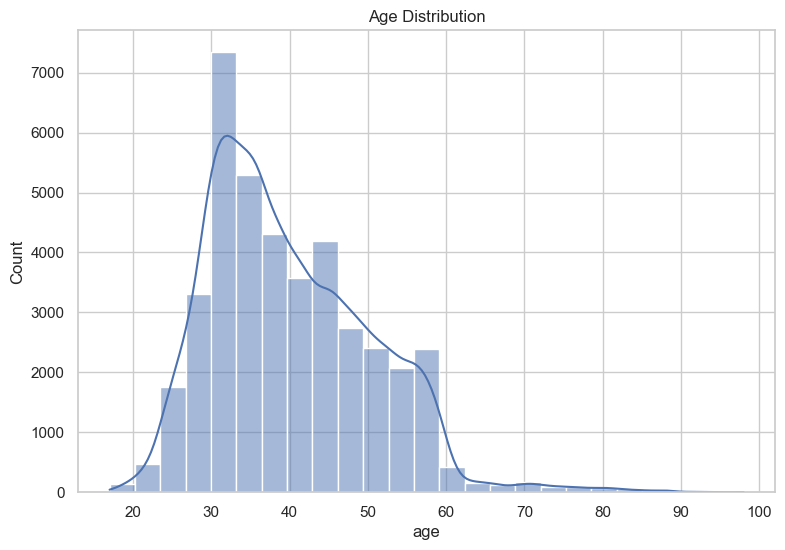

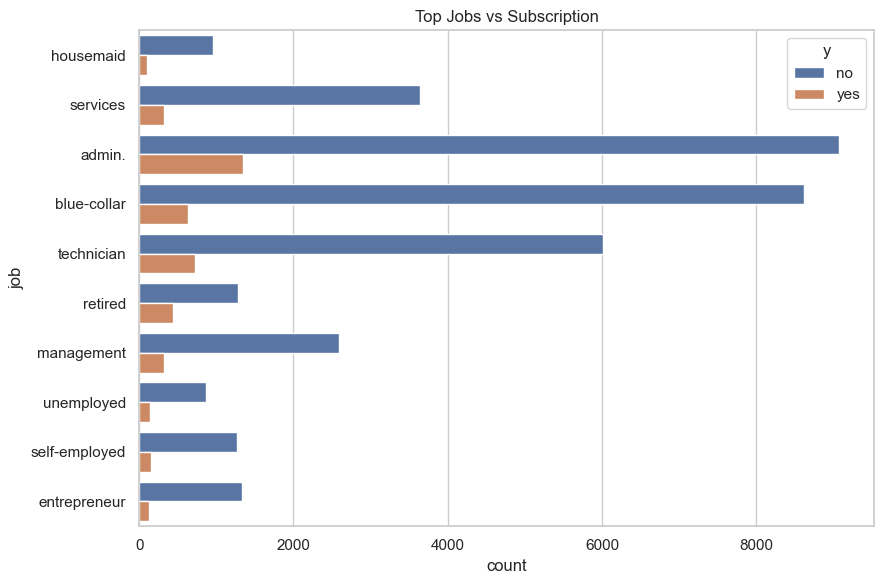

In [4]:
# Cell: EDA plots
# Target distribution
sns.countplot(data=df, x='y')
plt.title('Subscription Distribution (y)')
plt.savefig(os.path.join(NOTEBOOK_PLOTS, 'target_distribution.png'))
plt.show()

# Age distribution
sns.histplot(df['age'], bins=25, kde=True)
plt.title('Age Distribution')
plt.savefig(os.path.join(NOTEBOOK_PLOTS, 'age_distribution.png'))
plt.show()

# Job vs subscription (top jobs)
job_order = df['job'].value_counts().index[:10]
sns.countplot(data=df[df['job'].isin(job_order)], y='job', hue='y')
plt.title('Top Jobs vs Subscription')
plt.tight_layout()
plt.savefig(os.path.join(NOTEBOOK_PLOTS, 'job_vs_subscription.png'))
plt.show()

# 6. Preprocessing & cleaning (code)

In [5]:
# Cell: cleaning + preprocessing
# 1. Replace 'unknown' with NaN and drop rows with important nulls
df_clean = df.replace('unknown', pd.NA).dropna()
print('After dropping unknowns shape:', df_clean.shape)

# 2. Map target
df_clean['y'] = df_clean['y'].map({'yes':1, 'no':0})

# 3. Basic numeric conversions
for col in ['age','duration','campaign','pdays','previous']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# 4. Feature engineering (simple)
df_clean['total_contacts'] = df_clean['campaign'] + df_clean['previous']
df_clean['call_efficiency'] = df_clean['previous'] / (df_clean['campaign'] + 1)

# 5. Drop columns we won't use (if present)
for c in ['poutcome']:
    if c in df_clean.columns:
        pass  # keep for now — you may experiment

print(df_clean.shape)

After dropping unknowns shape: (30488, 21)
(30488, 23)


# 7. Prepare features for modeling (code)

In [6]:
# Cell: prepare X,y
y = df_clean['y']
X = df_clean.drop(columns=['y'])

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)
print('Feature matrix shape:', X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train/Test sizes:', X_train.shape, X_test.shape)

Feature matrix shape: (30488, 49)
Train/Test sizes: (24390, 49) (6098, 49)


# 8. Baseline model: Random Forest (code)

In [7]:
# Cell: train Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, os.path.join(MODELS_DIR, 'rf_baseline.pkl'))

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
print('Accuracy:', acc)
print('ROC AUC:', roc)
print('\nClassification report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8979993440472286
ROC AUC: 0.9308011436709932

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      5326
           1       0.63      0.48      0.54       772

    accuracy                           0.90      6098
   macro avg       0.78      0.72      0.74      6098
weighted avg       0.89      0.90      0.89      6098



# 9. Evaluation visuals (code)

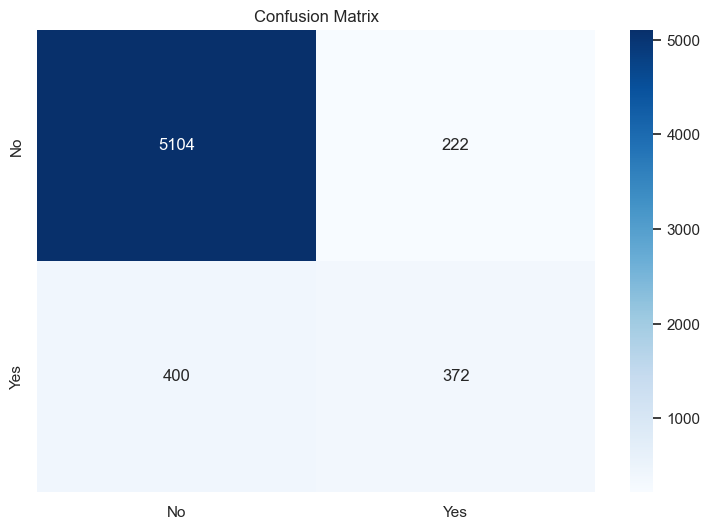

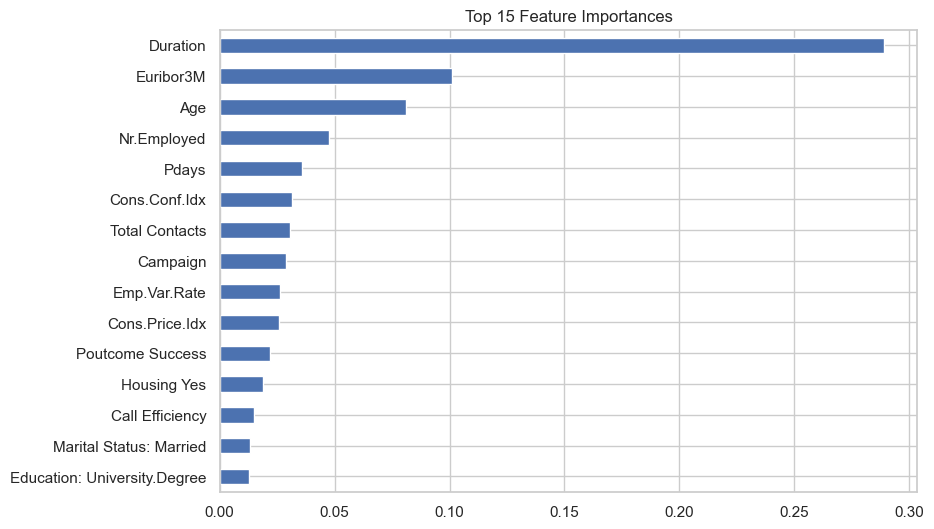

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.title('Confusion Matrix')
plt.savefig(os.path.join(NOTEBOOK_PLOTS, 'confusion_matrix.png'))
plt.show()

# Feature importance (top 15)
importances = pd.Series(model.feature_importances_, index=X.columns)

def clean_feature_name(feature):
    feature = feature.replace('_', ' ').title()
    if 'Marital' in feature:
        feature = feature.replace('Marital ', 'Marital Status: ')
    if 'Job' in feature:
        feature = feature.replace('Job ', 'Job: ')
    if 'Education' in feature:
        feature = feature.replace('Education ', 'Education: ')
    if 'Contact' in feature:
        feature = feature.replace('Contact ', 'Contact Method: ')
    return feature

fi = importances.sort_values(ascending=False).head(15)
fi.index = [clean_feature_name(i) for i in fi.index]
fi.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances')
plt.savefig(os.path.join(NOTEBOOK_PLOTS, 'feature_importances.png'))
plt.show()

# 10. Insights & Next Steps (markdown)

## Key Insights
- Customers with longer call durations and higher previous contact success are more likely to subscribe.
- Age segments and job types show different response patterns; these inform targeting rules.
- This model can help target marketing campaigns more effectively.